In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data
import torch
from torch import nn
from torch import optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
import torch.utils.data as data_utils
from PIL import Image, ImageFile
import json
from torch.optim import lr_scheduler
import time
import os
import argparse
import copy
import pandas as pd
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2
# Import useful sklearn functions
import sklearn
from sklearn.metrics import cohen_kappa_score, accuracy_score

import time
from tqdm import tqdm_notebook

import os
import seaborn as sns

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:

base_dir = "C:\\Users\\hsr30\\Documents\\minor-project\\datasets\\disease-grading-custom"

In [4]:
train_csv = pd.read_csv('C:\\Users\\hsr30\\Documents\\minor-project\\datasets\\disease-grading-custom\\groundtruths\\idrid-train.csv')
test_csv = pd.read_csv('C:\\Users\\hsr30\\Documents\\minor-project\\datasets\\disease-grading-custom\\groundtruths\\idrid-test.csv')
train_csv.head()

,Image name,diagnosis
0,IDRiD_001-0-90-3500,1
1,IDRiD_002-0-90-3500,1
2,IDRiD_003-0-90-3500,1
3,IDRiD_004-0-90-3500,1
4,IDRiD_005-0-90-3500,1


### Visualizing training data

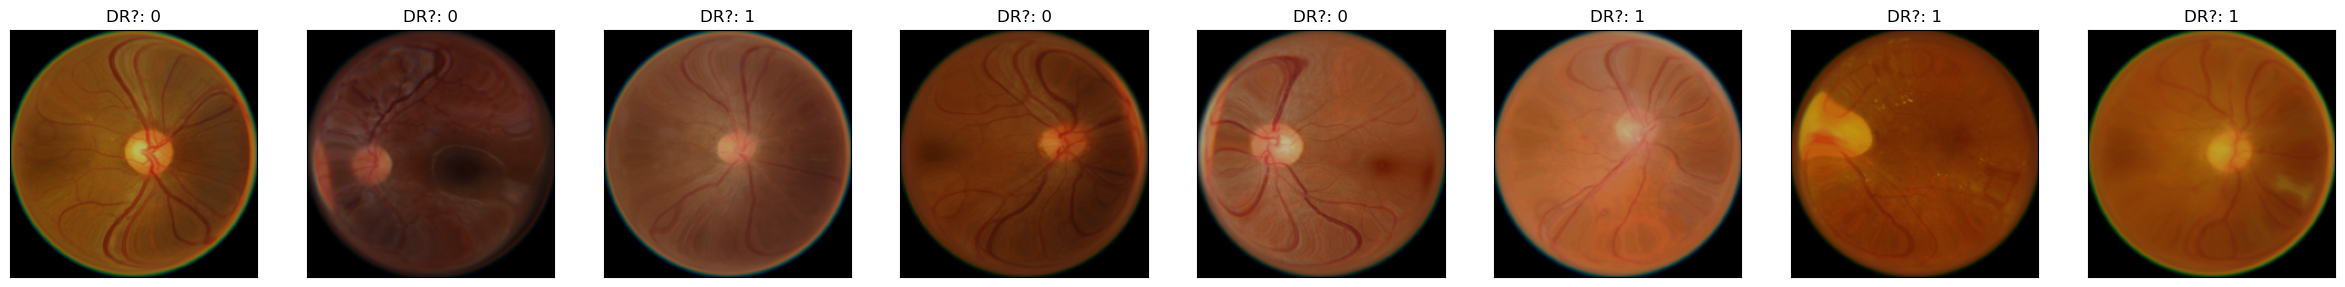

In [5]:
fig = plt.figure(figsize=(30, 6))
# display 20 images
train_imgs = os.listdir(os.path.join(base_dir, "final-training"))
for idx, img in enumerate(np.random.choice(train_imgs, 8)):
    ax = fig.add_subplot(8//8, 8, idx+1, xticks=[], yticks=[])
    im = Image.open(os.path.join(base_dir, "final-training", img))
    # resize to 224 x 224
    im = im.resize((224, 224))
    plt.imshow(im)

    lab = train_csv.loc[train_csv['Image name'] == img[0:-4], 'diagnosis'].values[0]
    ax.set_title('DR?: %s'%lab)

### Visualizing Test Data

In [6]:
### Dataset creation
# Our own custom class for datasets
class CreateDataset(torch.utils.data.Dataset):
    def __init__(self, df_data, data_dir, transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform
        print(self.data_dir)

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.png')
        if not os.path.exists(img_path):
            print(f"IMAGE MISSING {img_path}")
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [7]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((1200, 1200)),
    transforms.ToTensor(),
])
test_transforms = transforms.Compose([transforms.Resize((1200, 1200)),
                                      transforms.ToTensor(),])

In [8]:
train_path = os.path.join(base_dir, "final-training")
test_path = os.path.join(base_dir, "final-testing")

In [9]:
train_data = CreateDataset(df_data=train_csv, data_dir=train_path, transform=train_transforms)
test_data = CreateDataset(df_data=test_csv, data_dir=test_path, transform=test_transforms)

C:\Users\hsr30\Documents\minor-project\datasets\disease-grading-custom\final-training
C:\Users\hsr30\Documents\minor-project\datasets\disease-grading-custom\final-testing


In [10]:
valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [11]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [12]:
batch_size  = 2
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,sampler=train_sampler)
validloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)


In [13]:
print(f"training examples contain : {len(train_data)}")
print(f"testing examples contain : {len(test_data)}")

print(len(trainloader))
print(len(validloader))
print(len(testloader))

training examples contain : 413
testing examples contain : 102
166
41
51


### Training

In [14]:
model = models.resnet152(weights=torchvision.models.ResNet152_Weights.IMAGENET1K_V2) 

In [15]:
num_ftrs = model.fc.in_features 
out_ftrs = 2
  
model.fc = nn.Sequential(nn.Linear(num_ftrs, 512),nn.ReLU(),nn.Linear(512, out_ftrs),nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.00001) 

scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
model_base_path = "C:\\Users\\hsr30\\Documents\\minor-project\\disease-grading\\models"
num_existing_models = len(os.listdir(model_base_path))
model_save_name = f'classifier-{num_existing_models+1}.pt'
path = os.path.join(model_base_path, model_save_name)

In [17]:
# # to unfreeze more layers 
# for name,child in model.named_children():
#   if name in ['layer2','layer3','layer4','fc']:
#     print(name + 'is unfrozen')
#     for param in child.parameters():
#       param.requires_grad = True
#   else:
#     print(name + 'is frozen')
#     for param in child.parameters():
#       param.requires_grad = False

In [18]:
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.000001) 
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [19]:
def load_model(path):
  checkpoint = torch.load(path)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  return model

In [20]:
# model = load_model("../input/kernel4f121f3247/classifier.pt")

In [21]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
59193922


In [22]:
def train_and_test(e):
    epochs = e
    train_losses , test_losses, acc = [] , [], []
    valid_loss_min = np.Inf 
    model.to(device)
    model.train()
    
    print("Model Training started.....")
    for epoch in range(epochs):
      running_loss = 0
      batch = 0
      
      for images , labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        batch += 1
        if batch % 10 == 0:
            print(f" epoch {epoch + 1} batch {batch} completed", end="\r") 
      test_loss = 0
      accuracy = 0
      with torch.no_grad():
        print(f"\nvalidation started for {epoch + 1}")
        model.eval() 
        for images , labels in validloader:
          images, labels = images.to(device), labels.to(device)
          logps = model(images) 
          test_loss += criterion(logps,labels) 
          ps = torch.exp(logps)
          top_p , top_class = ps.topk(1,dim=1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor))
      train_losses.append(running_loss/len(trainloader))
      test_losses.append(test_loss/len(validloader))
      acc.append(accuracy)
      scheduler.step()
      print("Epoch: {}/{}.. ".format(epoch+1, epochs),"Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),"Valid Loss: {:.3f}.. ".format(test_loss/len(validloader)),
        "Valid Accuracy: {:.3f}".format(accuracy/len(validloader)))
      model.train()
      if test_loss/len(validloader) <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,test_loss/len(validloader))) 
        torch.save({
            'epoch': epoch,
            'model': model,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': valid_loss_min
            }, path)
        valid_loss_min = test_loss/len(validloader)    
    print('Training Completed Successfully !')    
    return train_losses, test_losses, acc


In [23]:
train_losses, valid_losses, acc = train_and_test(5)

Model Training started.....


 epoch 1 batch 160 completed
validation started for 1
Epoch: 1/5..  Training Loss: 0.683..  Valid Loss: 0.672..  Valid Accuracy: 0.634
Validation loss decreased (inf --> 0.672259).  Saving model ...
 epoch 2 batch 160 completed
validation started for 2
Epoch: 2/5..  Training Loss: 0.671..  Valid Loss: 0.658..  Valid Accuracy: 0.634
Validation loss decreased (0.672259 --> 0.658448).  Saving model ...
 epoch 3 batch 160 completed
validation started for 3
Epoch: 3/5..  Training Loss: 0.663..  Valid Loss: 0.644..  Valid Accuracy: 0.634
Validation loss decreased (0.658448 --> 0.643632).  Saving model ...
 epoch 4 batch 160 completed
validation started for 4
Epoch: 4/5..  Training Loss: 0.654..  Valid Loss: 0.631..  Valid Accuracy: 0.634
Validation loss decreased (0.643632 --> 0.631325).  Saving model ...
 epoch 5 batch 160 completed
validation started for 5
Epoch: 5/5..  Training Loss: 0.647..  Valid Loss: 0.618..  Valid Accuracy: 0.634
Validation loss decreased (0.631325 --> 0.617695).  Sa